# Cat & dog image classification with Keras

Выполнил: студент группы А-14м-16 Мигаль Иван.

Описание:

Решение задачи классификации образов (кошек и собак) с помощью keras. 

Для начала подключим необходимые модули и выведем их версии, в том числе версию python3. 
Также выведем абсолютный путь к папке с python3 (для разработчиков).

In [1]:
%matplotlib inline

import keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.utils import np_utils
from keras.models import Sequential, model_from_json
from keras.callbacks import EarlyStopping, Callback
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense

from sklearn.cross_validation import KFold, train_test_split
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.utils import shuffle

import os
import matplotlib
import urllib.request
import http.client
import json
from itertools import compress
import random

from fabric.api import execute, local, run, lcd, task
from tqdm import tqdm_notebook
import cv2

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import h5py
import sys
import getpass
import zipfile
import glob

usrname = getpass.getuser()

print('Версия python3:', sys.version)
print('Версия keras:', keras.__version__)
print('Keras backend:', keras.backend.backend())
print('Версия matplotlib:', matplotlib.__version__)
print('Версия urlib.request', urllib.request.__version__)
print('Версия numpy', np.__version__)
print('Версия OpenCV:', cv2.__version__)
print('Абсолютный путь к папке python3:', sys.executable)
print('Имя пользователя', usrname)

Using TensorFlow backend.


Версия python3: 3.5.2 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Версия keras: 2.0.9
Keras backend: tensorflow
Версия matplotlib: 1.5.3
Версия urlib.request 3.5
Версия numpy 1.11.1
Версия OpenCV: 3.2.0
Абсолютный путь к папке python3: /home/ivmig/anaconda3/bin/python
Имя пользователя ivmig


Теперь скачаем данные. Это размеченные картинки кошек и собак с соревнования Kaggle. Получить доступ к ним с одноименного сайта проблематично. К счастью, на сайте Майкрософт эти данные тоже есть, поэтому скачивать будем оттуда. Обучение нейросети на практике занимает от одного дня до недели. К счастью, есть уже готовые веса, которые можно скачать из Яндекс.Диска. Поэтому напишем функции, которые позволят скачать файл с весами модели.

In [2]:
# Скачать файл
def download(url, target='./', filename=None, locally=True):
    if filename:
        command = 'wget -O "%s" "%s"' % (os.path.join(target, filename), url)
    else:
        command = 'wget "%s"' % url

    if locally:
        with lcd(target):
            local(command)
    else:
        with cd(target):
            run(command)

# Скачать файл с Яндекс.Диска
def disk_download(url, target='./', locally=True):
    api = http.client.HTTPSConnection('cloud-api.yandex.net')
    url ='/v1/disk/public/resources/download?public_key=%s' % urllib.parse.quote(url)
    api.request('GET', url)
    resp = api.getresponse()
    file_info = json.loads(resp.read().decode("utf-8"))
    api.close()

    if resp.status == 200:
        filename = urllib.parse.parse_qs(urllib.parse.urlparse(file_info['href']).query)['filename'][0]
        download(file_info['href'], target, filename, locally)
    else:
        print(resp.status, resp.reason)
        print(file_info['error'], '\n', file_info['description'])

In [3]:
path_to_data_no_split = os.getcwd() + '/data_no_split/'
path_to_zip_file = path_to_data_no_split + 'cat_dog_images.zip'
weights_path = os.getcwd() + '/vgg16_weights.h5'
bottleneck_model_weights_path = os.getcwd() + '/bottleneck_weights.h5'
favorite_weights_path = os.getcwd() + '/favorite_weights.h5'

In [4]:
%%time

# Создаем директорию, если таковая отсутствует
if not os.path.exists(path_to_data_no_split):
    os.makedirs(path_to_data_no_split)

# Скачивание данных
url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip'
if not os.path.exists(path_to_zip_file):
    urllib.request.urlretrieve(url, path_to_zip_file)

# Распаковка архива
zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')
if not os.path.exists(path_to_data_no_split+'PetImages/'):
    zip_ref.extractall(path_to_data_no_split)
zip_ref.close()

# Cкачивание предообученной модели VGG16
url = 'https://yadi.sk/d/86p7x3py3RHExW'
if not os.path.exists(weights_path):
    disk_download(url, target=os.getcwd() + '/')

# Cкачивание предообученной модели классификатора
url = 'https://yadi.sk/d/v0JC9lw-3RSbfi'
if not os.path.exists(bottleneck_model_weights_path):
    disk_download(url, target=os.getcwd() + '/')

# Cкачивание предообученной модели
url = 'https://yadi.sk/d/UYa5-0s43RSbDY'
if not os.path.exists(favorite_weights_path):
    disk_download(url, target=os.getcwd() + '/')

CPU times: user 360 ms, sys: 16 ms, total: 376 ms
Wall time: 407 ms


Теперь необходимо проверить картинки на качество: некоторые файлы могу быть "битыми". Для этого определим функцию `check_class_num`. В ней мы проверяем, сколько изображений можно использовать для обучения, сквозной проверки и теста. Заодно и получить список имен файлов, которые можно использовать. Он необходим для поэлементного чтения картинок для обучения, сквозной проверки и теста. Это выгодно, когда мало оперативной памяти.

In [5]:
# Гиперпараметры
val_split = .33 
classes = ["dog", "cat"]
folders = ["Dog", "Cat"]
num_classes = len(classes)

# Разрешение изображения
img_width, img_height = 224, 224

# Посчитать число небитых картинок
def check_class_num():
    cat_dog_num = {folders[0] : 0, folders[1] : 0}
    cat_dog_list = {folders[0] : [], folders[1] : []}
    
    for fld in folders:
        index = folders.index(fld)
        path = os.path.join(path_to_data_no_split+'PetImages/', fld, '*g')
        files = glob.glob(path)
        i = 0
        
        for fl in tqdm_notebook(files):
            flbase = os.path.basename(fl)
            try:
                mpimg.imread(fl)
            except:
                continue
            cat_dog_num[fld] += 1
            cat_dog_list[fld] += [fl]
            
    return cat_dog_num, cat_dog_list

# Загрузить изображения (Необходимо следить за памятью)
def load_images(cat_dog_list, img_count=100):
    X = []
    X_id = []
    Y = []
    images = []

    print('Загрузка изображений для обучения...')
    for fld in folders:
        index = folders.index(fld)
        for fl in tqdm_notebook(cat_dog_list[fld][:min(img_count, len(cat_dog_list[fld]))]):
            img = image.load_img(fl, target_size=(img_width, img_height))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            X.append(x[0])
            images.append(img)
            X_id.append(fl)
            Y.append(index)

    X = np.array(X)
    #X = X.transpose((0, 3, 1, 2)) # Зависит от backend'a - ставить для Threano
    Y = np_utils.to_categorical(Y, num_classes)
    print('Загрузка изображений завершена!')
    return X, Y, X_id, images

Давайте посчитаем число небитых изображений. После расчета видно, что картинок очень много. Это очень хорошо

После того, как мы "очистили" картинки от битых, надо загрузить их. Если памяти много, то можно загрузить все картинки. Однако сейчас у нас доступно не очень много памяти (MyBinder обеспечивает 8 Гб оперативной памяти, что очень мало). Поэтому загрузим часть картинок. Их количество обозначим `img_count`.

In [6]:
cat_dog_list = json.load(open('cat_dog_list.json'))
img_count = 5
X, Y, X_id, images = load_images(cat_dog_list, img_count=img_count)
np.shape(X), np.shape(Y)

Загрузка изображений для обучения...


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Загрузка изображений завершена!


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


((10, 224, 224, 3), (10, 2))

Сейчас определим модель нейронной сети VGG-16 с модификациями для бинарной классификации.

In [7]:
# VGG16 архитертура с модификацией для бинарной классификации.
def build_model():
    
    # VGG16
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(img_width, img_height, 3)))

    model.add(Conv2D(64, (3, 3), activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Загрузить веса для VGG16
    f = h5py.File(weights_path)
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):
            # Не берем последний полносвязный слой
            break
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        weights_T = [np.array(x).T for x in weights]
        weights = weights_T  
        model.layers[k].set_weights(weights)
    f.close()
    
    # Строим классификатор и вставляем его в конец сверточной сети
    bottleneck_model = Sequential()
    bottleneck_model.add(Flatten(input_shape=model.output_shape[1:]))
    bottleneck_model.add(Dense(256, activation='relu'))
    bottleneck_model.add(Dropout(0.5))
    bottleneck_model.add(Dense(num_classes, activation='softmax'))
    
    # Загружаем веса для классификатора
    bottleneck_model.load_weights(bottleneck_model_weights_path)

    # Добавляем классификатор в VGG16 архитектуру
    model.add(bottleneck_model)

    # Веса до последнего сверточного блока оставляем без изменения во время дообучения
    for layer in model.layers[:25]:
        layer.trainable = False
        
    # Компилируем
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.9))
    return model

Теперь создадим модель и загрузим для нее веса.

In [8]:
%time

model = build_model()
model.load_weights(favorite_weights_path)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.53 µs


In [9]:
X_valid = X
Y_valid = Y

Затем используем модель и отобразим результаты

In [10]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
            
    if cls_pred is None:
        images, cls_true = zip(*[(images[i], cls_true[i]) for i in random_indices])
    else:
        images, cls_true, cls_pred = zip(*[(images[i], cls_true[i], cls_pred[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        image = images[i]
        ax.imshow(image)

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [11]:
def plot_example(cls_pred):

    # Get the true classes for those images.
    labels = np.array([classes[np.argmax(x)] for x in Y_valid])
    cls_true = labels
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [12]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_validation_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the validation set.

    # Get the true classifications for the test-set.
    cls_true = [classes[np.argmax(x)] for x in Y_valid]
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred,
                          labels=classes)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [13]:
def print_validation_accuracy(show_example=False, show_confusion_matrix=False):
    
    cls_pred = np.array([classes[np.argmax(x)] for x in model.predict(X_valid)])
    
    # Convenience variable for the true class-numbers of the validation set.
    cls_true = np.array([classes[np.argmax(x)] for x in Y_valid])

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / len(Y_valid)

    # Print the accuracy.
    msg = "Accuracy on validation set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, len(Y_valid)))

    # Plot some examples of mis-classifications, if desired.
    if show_example:
        print("Example errors and rights:")
        plot_example(cls_pred=cls_pred)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

Accuracy on validation set: 100.0% (10 / 10)
Example errors and rights:


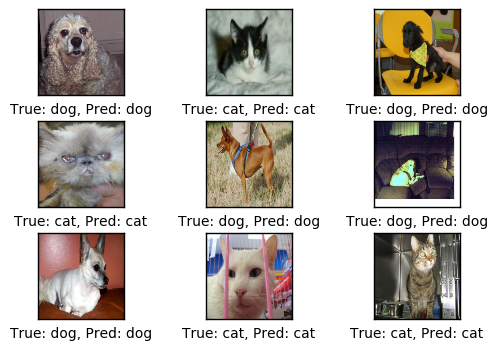

Confusion Matrix:
[[5 0]
 [0 5]]


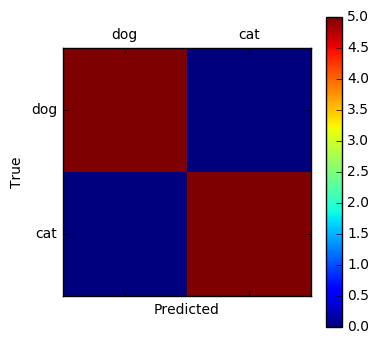

CPU times: user 18.8 s, sys: 376 ms, total: 19.2 s
Wall time: 19.7 s


In [14]:
%%time

print_validation_accuracy(show_example=True, show_confusion_matrix=True)

Predicted: Dasha.jpg is cat


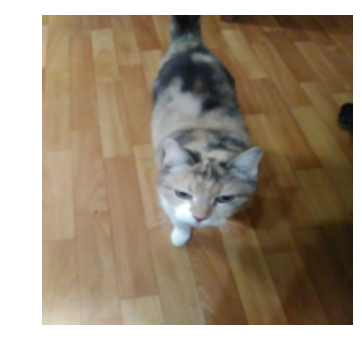

In [15]:
img = image.load_img('Dasha.jpg', target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)

fig, ax = plt.subplots()
ax.imshow(img)
ax.axis('off')  # Очистка от разметки осей
print('Predicted: Dasha.jpg is', classes[np.argmax(preds)])

Predicted: Tosha.jpg is dog


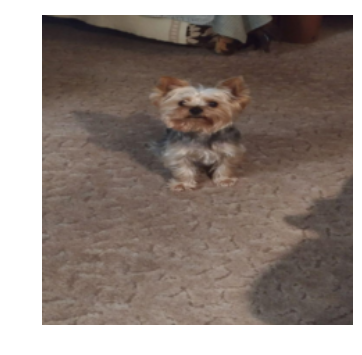

In [16]:
img = image.load_img('Tosha.jpg', target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)

fig, ax = plt.subplots()
ax.imshow(img)
ax.axis('off')  # Очистка от разметки осей
print('Predicted: Tosha.jpg is', classes[np.argmax(preds)])